In [2]:
import csv # for writing dataframes to csv
import random # for making a random choice
from collections import Counter # for counting elements in a list
import os # for scanning directories
import itertools

import kintypes as kt # bringing large lists of kin types into the namespace
import pandas as pd # for building dataframes
import matplotlib.pyplot as plt # for plotting
import math # for calculating logs

# Frankenlanguage simulation

A frankenlanguage is an artificial kinship system generated by randomly splicing generations of kinship terminology together, such that the Generation N terms come from one randomly selected language, and the Generation N+1 terms come from another randomly selected language (sampled with replacement).

Why do this? When looking for typological tendencies in the world's kinship systems, we need to know whether or not we can expect the tendencies we observe to have arisen by chance. By running the same analyses on real kinship data (from www.kinbank.net) as well as the frankenlanguages, we can observe whether the tendency is stronger for real languages than randomly generated ones.

# Building the frankenlanguages

First, we need a way to access the csv datafiles from Kinbank. There's one file for each language, which details which kin terms correspond to which kin types in that language. We're interested in two columns from these files: the 'parameter' column, giving us the kin type, and the 'word' column, giving us the kin term that corresponds to that type in a particular language.

In [3]:
def get_kb_files():
    files = []
    path = '../languages/kinbank'
    directory = os.scandir(path)
    for file in directory:
        files.append(file.name)
    return files

In [4]:
all_kb_files = get_kb_files()

Now we have a long list of all of the kinbank filenames, we need a function to pick one at random from this list.

In [5]:
def random_language(all_data):
    language = random.choice(all_data)
    # print(language)
    return language

To splice the kinship systems from the two languages together, we'll need access to the kinship terms in each kinbank file. This function opens a kinbank file, and extracts data from two columns: 'parameter' (a code corresponding to a kin type) and 'word' (the term used in this language to refer to that kin type).

In [6]:
def get_kin_terms(filepath):
    kin_system = {}
    with open(filepath, encoding='utf8') as f:
        csv_reader = csv.DictReader(f)
        next(csv_reader) # to skip the header row
        for line in csv_reader:
            kin_type = line['parameter']
            kin_term = line['word']
            kin_system[kin_type] = kin_term
    return kin_system

Let's test this to see what a kinship system looks like for a random language.

In [312]:
random.seed(47) # for testing purposes only
#random.seed(28)
language_x = random_language(all_kb_files)

kin_system_x = get_kin_terms('../languages/kinbank/' + language_x)

print(language_x)
print(kin_system_x)

Murrinhpatha_murr1258.csv
{'myB': 'ngathan', 'feB': 'ngathan', 'fyB': 'ngathan', 'meZ': 'munak', 'myZ': 'munak', 'feZ': 'munak', 'fyZ': 'munak', 'mF': 'yile', 'mM': 'kale', 'fF': 'yile', 'fM': 'kale', 'mS': 'wakal', 'fS': 'wakal', 'mD': 'wakal', 'fD': 'wakal', 'mSS': 'kangkurl', 'mSD': 'kangkurl', 'mDS': 'thamunh', 'mDD': 'thamunh', 'fSS': 'mangka', 'fSD': 'mangka', 'fDS': 'kanagunku', 'fDD': 'kangiru', 'mFF': 'kangkurl', 'mFM': 'mangka', 'mMF': 'thamunh', 'mMM': 'kawu', 'fFF': 'kangkurl', 'fFM': 'mangka', 'fMF': 'thamunh', 'fMM': 'kawu', 'meBS': 'wakal', 'myBS': 'wakal', 'meZS': 'muluk wakal', 'myZS': 'muluk wakal', 'meBD': 'wakal', 'myBD': 'wakal', 'meZD': 'newuy wakal', 'myZD': 'newuy wakal', 'feBS': 'muluk wakal', 'fyBS': 'muluk wakal', 'feZS': 'wakal', 'fyZS': 'wakal', 'feBD': 'newuy wakal', 'fyBD': 'newuy wakal', 'feZD': 'wakal', 'fyZD': 'wakal', 'mFeB': 'yile', 'mFyB': 'yile', 'mFeZ': 'pipi', 'mFyZ': 'pipi', 'mMeB': 'kaka', 'mMyB': 'kaka', 'mMeZ': 'kale', 'mMyZ': 'kale', 'fFeB':

Now we need to filter out the information we're interested in - for the purposes of this study, we want to combine the Generation N terms (siblings and cousins) from one language with the Generation N+1 terms (parents' siblings) from another. In `kintypes` we have a list of the kin type codes for GN and GN+1, so we can quickly filter out codes that are not in these lists.

In [7]:
def filter_generations(kin_system,generation):
    if generation == 1:
        g = {kin_term:kin_system[kin_term] for kin_term in kin_system if kin_term in kt.generation_n}
    elif generation == 2:
        g = {kin_term:kin_system[kin_term] for kin_term in kin_system if kin_term in kt.generation_n1}
    else:
        print("Enter 1 for Ego's generation or 2 for Ego's parents' generation. Nothing else is permitted.")
    return g

If we test that for generation N of language X, we can see that only the codes for Ego's siblings and cousins remain.

In [11]:
test_generation_filter = filter_generations(kin_system_x,1)

print(test_generation_filter)

{'myB': 'ngathan', 'feB': 'ngathan', 'fyB': 'ngathan', 'meZ': 'munak', 'myZ': 'munak', 'feZ': 'munak', 'fyZ': 'munak', 'mFBS': 'ngathan', 'mFZS': 'pugarli', 'mMBS': 'pugarli', 'mMZS': 'ngathan', 'mFBD': 'munak', 'mFZD': 'pugarli', 'mMBD': 'pugarli', 'mMZD': 'munak', 'fFBS': 'ngathan', 'fFZS': 'pugarli', 'fMBS': 'pugarli', 'fMZS': 'ngathan', 'fFBD': 'munak', 'fFZD': 'pugarli', 'fMBD': 'pugarli', 'fMZD': 'munak', 'mFeBS': 'ngathan', 'mFyBS': 'ngathan', 'mFeZS': 'pugarli', 'mFyZS': 'pugarli', 'mFeBD': 'munak', 'mFyBD': 'munak', 'mFeZD': 'pugarli', 'mFyZD': 'pugarli', 'mMeBS': 'pugarli', 'mMyBS': 'pugarli', 'mMeZS': 'ngathan', 'mMyZS': 'ngathan', 'mMeBD': 'pugarli', 'mMyBD': 'pugarli', 'mMeZD': 'munak', 'mMyZD': 'munak', 'mFBeS': 'ngathan', 'mFByS': 'ngathan', 'mFZeS': 'pugarli', 'mFZyS': 'pugarli', 'mFBeD': 'munak', 'mFByD': 'munak', 'mFZeD': 'pugarli', 'mFZyD': 'pugarli', 'mMBeS': 'pugarli', 'mMByS': 'pugarli', 'mMZeS': 'ngathan', 'mMZyS': 'ngathan', 'mMBeD': 'pugarli', 'mMByD': 'pugarli

Now that we can pick a language at random, extract the kin terms, and filter by the kin types we're interested in, we can build a frankenlanguage!

In [12]:
def create_frankenlanguage():
    filepath = '../languages/kinbank/'
    gN = filter_generations(get_kin_terms(filepath + random_language(all_kb_files)),1)
    gN1 = filter_generations(get_kin_terms(filepath + random_language(all_kb_files)),2)
    frankenlanguage = {**gN, **gN1}
    return frankenlanguage

Aaaaaand as usual we'll just test that function as well to make sure it does what we expect: picking two languages at random, and combining the generation N terms (siblings and cousins) from one of them with the generation N+1 (parents' siblings) from the other.

In [13]:
frankenlanguage_test = create_frankenlanguage()

print(frankenlanguage_test)

{'myB': 'arik', 'feB': 'arik', 'fyB': 'arik', 'meZ': 'arik', 'myZ': 'arik', 'feZ': 'arik', 'fyZ': 'arik', 'mFBS': 'aken', 'mFZS': 'aken', 'mMBS': 'aken', 'mMZS': 'aken', 'mFBD': 'aken', 'mFZD': 'aken', 'mMBD': 'aken', 'mMZD': 'aken', 'fFBS': 'aken', 'fFZS': 'aken', 'fMBS': 'aken', 'fMZS': 'aken', 'fFBD': 'aken', 'fFZD': 'aken', 'fMBD': 'aken', 'fMZD': 'aken', 'mFeBS': 'aken', 'mFyBS': 'aken', 'mFeZS': 'aken', 'mFyZS': 'aken', 'mFeBD': 'aken', 'mFyBD': 'aken', 'mFeZD': 'aken', 'mFyZD': 'aken', 'mMeBS': 'aken', 'mMyBS': 'aken', 'mMeZS': 'aken', 'mMyZS': 'aken', 'mMeBD': 'aken', 'mMyBD': 'aken', 'mMeZD': 'aken', 'mMyZD': 'aken', 'mFBeS': 'aken', 'mFByS': 'aken', 'mFZeS': 'aken', 'mFZyS': 'aken', 'mFBeD': 'aken', 'mFByD': 'aken', 'mFZeD': 'aken', 'mFZyD': 'aken', 'mMBeS': 'aken', 'mMByS': 'aken', 'mMZeS': 'aken', 'mMZyS': 'aken', 'mMBeD': 'aken', 'mMByD': 'aken', 'mMZeD': 'aken', 'mMZyD': 'aken', 'fFeBS': 'aken', 'fFyBS': 'aken', 'fFeZS': 'aken', 'fFyZS': 'aken', 'fFeBD': 'aken', 'fFyBD': 

And now we have all the tools we need to build a frankenlanguage! And we can do it as many times as we want. First, though, we probably want some infrastructure for actually making useful inferences about the frankenlanguages (and the real data, too). So let's do that next.

# Feature distinctions

One of the typological features of kinship systems we're investigating is whether there is a correlation between the number of distinctions made along a single featural dimension in generation N and generation N+1. That is to say, does a higher proportion of kin terms distinguished by gender among siblings and cousins correlate with a high proportion of kin terms distinguished by gender among parents' siblings? What about age? And side of the family?

To analyse this, we need to work out what the proportion of terms distinguished by a single feature is in each generation - both in the real kinship systems and in the frankenlanguages. In `kintypes`, we have a bunch of lists of tuples - each tuple contains a pair of kin types which differ by one distinctive feature - e.g. meB (male speaker's elder brother) and meZ (male speaker's elder sister), which differ only by gender. There's two lists of pairs for each kind of feature distinction - one for the terms in Generation N and one for the terms in Generation N+1. By checking whether the kin terms for these pairs of types are the same, we can get an idea of how often such a distinction is made (and ultimately, whether there's a correlation between using this feature frequently in one generation and using it in the other).

So, let's first define a function that checks whether two things are equal.

In [14]:
def check_equality(one,two):
    if one == two:
        return 0
    return 1

Specifically, we want to check whether two kin terms in a given language are equal, so we need to cross-reference our pairs of kin types in `kintypes` with the language's kinship system in order to work out what terms to compare. 

Since we want a proportion of relationships which use this distinction, we have our `check_equality` function return either 0 (no distinction) or 1 (yes distinction).  Not all languages have all the relevant data, so just in case we try to run the below function on a language that is missing one or both members of a pair, we have it give a `null` score if this instance arises.

In [15]:
def find_distinctions(pairs,kin_system):
    distinctions = {}
    for pair in pairs:
        if pair[0] in kin_system.keys() and pair[1] in kin_system.keys():
            distinctions[pair] = check_equality(kin_system[pair[0]],kin_system[pair[1]])
        else:
            distinctions[pair] = 'null'
    
    return distinctions
            

Let's test this on the kinship system from language X, using the gender distinct pairs from our module `kintypes`.

In [16]:
gN_test_distinctions = find_distinctions(kt.ge_gN,kin_system_x)
gN1_test_distinctions = find_distinctions(kt.ge_gN1,kin_system_x)

print(filter_generations(kin_system_x,1), '\n\n', filter_generations(kin_system_x,2), '\n')
      
print(gN_test_distinctions)

print(gN1_test_distinctions)

{'myB': 'ngathan', 'feB': 'ngathan', 'fyB': 'ngathan', 'meZ': 'munak', 'myZ': 'munak', 'feZ': 'munak', 'fyZ': 'munak', 'mFBS': 'ngathan', 'mFZS': 'pugarli', 'mMBS': 'pugarli', 'mMZS': 'ngathan', 'mFBD': 'munak', 'mFZD': 'pugarli', 'mMBD': 'pugarli', 'mMZD': 'munak', 'fFBS': 'ngathan', 'fFZS': 'pugarli', 'fMBS': 'pugarli', 'fMZS': 'ngathan', 'fFBD': 'munak', 'fFZD': 'pugarli', 'fMBD': 'pugarli', 'fMZD': 'munak', 'mFeBS': 'ngathan', 'mFyBS': 'ngathan', 'mFeZS': 'pugarli', 'mFyZS': 'pugarli', 'mFeBD': 'munak', 'mFyBD': 'munak', 'mFeZD': 'pugarli', 'mFyZD': 'pugarli', 'mMeBS': 'pugarli', 'mMyBS': 'pugarli', 'mMeZS': 'ngathan', 'mMyZS': 'ngathan', 'mMeBD': 'pugarli', 'mMyBD': 'pugarli', 'mMeZD': 'munak', 'mMyZD': 'munak', 'mFBeS': 'ngathan', 'mFByS': 'ngathan', 'mFZeS': 'pugarli', 'mFZyS': 'pugarli', 'mFBeD': 'munak', 'mFByD': 'munak', 'mFZeD': 'pugarli', 'mFZyD': 'pugarli', 'mMBeS': 'pugarli', 'mMByS': 'pugarli', 'mMZeS': 'ngathan', 'mMZyS': 'ngathan', 'mMBeD': 'pugarli', 'mMByD': 'pugarli

Finally, we can add all these 0s and 1s and divide by the total number of possible distinctions to get a `distinction score` for each generation of the kinship system. `generation_pairs` is a list of pairs from `kintypes` which contains all the relevant pairs for Generation N or Generation N+1. At least for now, we're going to remove all the `null`s from the total number of distinctions - otherwise our analysis gets completely skewed by incomplete data. So the function below takes all the non-`null` distinctions, puts them in a list, sums that list and divides that sum by the length of the list. If the length of the list is 0, then we can't get any useful information from this language (there aren't any non-`null` scores). We give it a score of `discard` so we can easily discard it from the analysis later.

In [17]:
def results_by_generation(distinctions):
    values = []
    for pair in distinctions:
        #if pair in generation:
            values.append(distinctions[pair])
            
    values = [x for x in values if x != 'null']
    
    # print(values) # to test that the list comprehension has filtered out the 'nulls' correctly
    
    if len(values) == 0:
        pass
    else:
        gen = sum(values)/len(values)
    
        # print(sum(values),len(values)) # to check what the number of distinctions is and 
                                     # how many possible distinctions there were
        return gen

A quick test shows that our random choice of language (in this case, Murrinhpatha) has 53% of its generation N terms distinguished by gender, and 100% of its generation N+1 terms distinguished by gender.

In [18]:
test_results_n = results_by_generation(gN_test_distinctions)
test_results_n1 = results_by_generation(gN1_test_distinctions)

print('Generation N:', test_results_n, '\nGeneration N+1:', test_results_n1)

Generation N: 0.5348837209302325 
Generation N+1: 1.0


So we now have (1) a way to access the data from kinbank (2) a way to generate frankenlanguages, and (3) a way to calculate the proportion of distinctions along a feature dimension in each generation of a kinship system. Now we combine those, to calculate proportions of distinctions en masse.

## Feature distinctions in Kinbank

Let's start with the kinbank data, since it already exists. We already have our list of kinbank filenames from earlier - `all_kb_files`, so we need to extract the relevant kin terms from each of those files using the `get_kin_terms` function, run them through our `results_by_generation` function, and save the scores to a new data structure.

In [19]:
def kb_proportion_scores(filepath,gN_pairs,gN1_pairs):
    scores = []
    
    for file in all_kb_files:
        row = {}
        terms = get_kin_terms(filepath + file)
        
        row['language'] = file
        row['generation_n'] = results_by_generation(find_distinctions(gN_pairs,terms))
        row['generation_n+1'] = results_by_generation(find_distinctions(gN1_pairs,terms))
        row['set'] = 'kinbank'
        row['data_type'] = 'kinbank'
        
        scores.append(row)
        
    return pd.DataFrame(scores)

`kb_proportion_scores` takes the filepath to the kinbank languages, a list of feature-distinct pairs, and a list of feature-distinct pairs filtered by generation and outputs a dictionary where the keys are languages (kinbank filesnames) and the value is a list of the proportion scores for Generation N and Generation N+1.

In [20]:
kb_filepath = '../languages/kinbank/'
ge_kb_scores = kb_proportion_scores(kb_filepath,kt.ge_gN,kt.ge_gN1)
ag_kb_scores = kb_proportion_scores(kb_filepath,kt.ag_gN,kt.ag_gN1)
si_kb_scores = kb_proportion_scores(kb_filepath,kt.si_gN,kt.si_gN1)

print(ge_kb_scores)

                       language  generation_n  generation_n+1      set  \
0         'Are'are_area1240.csv      0.090909        1.000000  kinbank   
1             Abui_abui1241.csv      1.000000        1.000000  kinbank   
2           Ache╠ü_ache1246.csv      0.111111        1.000000  kinbank   
3         Achinese_achi1257.csv      1.000000        1.000000  kinbank   
4           Achuar_achu1249.csv      0.217391        0.333333  kinbank   
...                         ...           ...             ...      ...   
1226  Zabana_(Kia)_zaba1237.csv      0.000000             NaN  kinbank   
1227        Zigula_zigu1242.csv      0.000000        1.000000  kinbank   
1228         Zinza_zinz1238.csv      1.000000        1.000000  kinbank   
1229          Zulu_zulu1248.csv      0.302326        1.000000  kinbank   
1230          Zuni_zuni1245.csv      1.000000        1.000000  kinbank   

     data_type  
0      kinbank  
1      kinbank  
2      kinbank  
3      kinbank  
4      kinbank  
...      

## Feature distinctions in the frankenlanguages

Now we'll extract this proportion data from some frankenlanguages in a similar way, except this time instead of importing the data from existing files, we'll have to generate the language data in situ.

In [21]:
def fl_proportion_scores(times,gN_pairs,gN1_pairs,count):
    df = []
    
    for i in range(times):
        score = {}
        frankenlanguage = create_frankenlanguage()
#         print(frankenlanguage)
        gN_distinctions = find_distinctions(gN_pairs,frankenlanguage)
#         print(gN_distinctions)
        gN1_distinctions = find_distinctions(gN1_pairs,frankenlanguage)
#         print(gN1_distinctions)
        score['language'] = 'frankenlanguage_' + str(i)
        score['generation_n'] = (results_by_generation(gN_distinctions))
        score['generation_n+1'] = (results_by_generation(gN1_distinctions))
        score['set'] = (str(count))
        score['data_type'] = 'simulation'
        df.append(score)
    return df

A quick test with 10 frankenlanguages, to make sure it outputs what we expect:

In [22]:
test_df = fl_proportion_scores(10,kt.ge_gN,kt.ge_gN1,1)

Yep - we're getting scores for each generation, and by printing the language and the distinctions inside the function, we can see it's all matching up. What a dream. 

# Running The Feature Distinction Simulation

It's finally time. This next bit of code is a function that runs `fl_proportion_scores` 1000 times, generating 1000 frankenlanguages and extracting the proportion of gender distinctions in each of them. This matches the set of approximately 1000 real languages we have in the kinbank dataset. That's then wrapped up in a function that also runs 1000 times. So ultimately we end up 1000 simulated versions of the real data (or we do 1000 experiments, if you prefer to think about it that way!) to run our analysis on. The data is returned in the form of a `pandas` dataframe.

In [23]:
def simulate_data(times,gN_pairs,gN1_pairs):
    count = 0
    all_data = []
    
    for i in range(times):
        count += 1
        simulation = fl_proportion_scores(times,gN_pairs,gN1_pairs,count)
        all_data.append(simulation)
        print(str(count) + ' simulations are complete!')
        
    return pd.DataFrame([item for sublist in all_data for item in sublist])

And now we run it! For **gender**:

In [22]:
ge_simulation = simulate_data(1000,kt.ge_gN,kt.ge_gN1)

1 simulations are complete!
2 simulations are complete!
3 simulations are complete!
4 simulations are complete!
5 simulations are complete!
6 simulations are complete!
7 simulations are complete!
8 simulations are complete!
9 simulations are complete!
10 simulations are complete!
11 simulations are complete!
12 simulations are complete!
13 simulations are complete!
14 simulations are complete!
15 simulations are complete!
16 simulations are complete!
17 simulations are complete!
18 simulations are complete!
19 simulations are complete!
20 simulations are complete!
21 simulations are complete!
22 simulations are complete!
23 simulations are complete!
24 simulations are complete!
25 simulations are complete!
26 simulations are complete!
27 simulations are complete!
28 simulations are complete!
29 simulations are complete!
30 simulations are complete!
31 simulations are complete!
32 simulations are complete!
33 simulations are complete!
34 simulations are complete!
35 simulations are comp

278 simulations are complete!
279 simulations are complete!
280 simulations are complete!
281 simulations are complete!
282 simulations are complete!
283 simulations are complete!
284 simulations are complete!
285 simulations are complete!
286 simulations are complete!
287 simulations are complete!
288 simulations are complete!
289 simulations are complete!
290 simulations are complete!
291 simulations are complete!
292 simulations are complete!
293 simulations are complete!
294 simulations are complete!
295 simulations are complete!
296 simulations are complete!
297 simulations are complete!
298 simulations are complete!
299 simulations are complete!
300 simulations are complete!
301 simulations are complete!
302 simulations are complete!
303 simulations are complete!
304 simulations are complete!
305 simulations are complete!
306 simulations are complete!
307 simulations are complete!
308 simulations are complete!
309 simulations are complete!
310 simulations are complete!
311 simula

552 simulations are complete!
553 simulations are complete!
554 simulations are complete!
555 simulations are complete!
556 simulations are complete!
557 simulations are complete!
558 simulations are complete!
559 simulations are complete!
560 simulations are complete!
561 simulations are complete!
562 simulations are complete!
563 simulations are complete!
564 simulations are complete!
565 simulations are complete!
566 simulations are complete!
567 simulations are complete!
568 simulations are complete!
569 simulations are complete!
570 simulations are complete!
571 simulations are complete!
572 simulations are complete!
573 simulations are complete!
574 simulations are complete!
575 simulations are complete!
576 simulations are complete!
577 simulations are complete!
578 simulations are complete!
579 simulations are complete!
580 simulations are complete!
581 simulations are complete!
582 simulations are complete!
583 simulations are complete!
584 simulations are complete!
585 simula

826 simulations are complete!
827 simulations are complete!
828 simulations are complete!
829 simulations are complete!
830 simulations are complete!
831 simulations are complete!
832 simulations are complete!
833 simulations are complete!
834 simulations are complete!
835 simulations are complete!
836 simulations are complete!
837 simulations are complete!
838 simulations are complete!
839 simulations are complete!
840 simulations are complete!
841 simulations are complete!
842 simulations are complete!
843 simulations are complete!
844 simulations are complete!
845 simulations are complete!
846 simulations are complete!
847 simulations are complete!
848 simulations are complete!
849 simulations are complete!
850 simulations are complete!
851 simulations are complete!
852 simulations are complete!
853 simulations are complete!
854 simulations are complete!
855 simulations are complete!
856 simulations are complete!
857 simulations are complete!
858 simulations are complete!
859 simula

For **age**:

In [23]:
ag_simulation = simulate_data(1000,kt.ag_gN,kt.ag_gN1)

1 simulations are complete!
2 simulations are complete!
3 simulations are complete!
4 simulations are complete!
5 simulations are complete!
6 simulations are complete!
7 simulations are complete!
8 simulations are complete!
9 simulations are complete!
10 simulations are complete!
11 simulations are complete!
12 simulations are complete!
13 simulations are complete!
14 simulations are complete!
15 simulations are complete!
16 simulations are complete!
17 simulations are complete!
18 simulations are complete!
19 simulations are complete!
20 simulations are complete!
21 simulations are complete!
22 simulations are complete!
23 simulations are complete!
24 simulations are complete!
25 simulations are complete!
26 simulations are complete!
27 simulations are complete!
28 simulations are complete!
29 simulations are complete!
30 simulations are complete!
31 simulations are complete!
32 simulations are complete!
33 simulations are complete!
34 simulations are complete!
35 simulations are comp

278 simulations are complete!
279 simulations are complete!
280 simulations are complete!
281 simulations are complete!
282 simulations are complete!
283 simulations are complete!
284 simulations are complete!
285 simulations are complete!
286 simulations are complete!
287 simulations are complete!
288 simulations are complete!
289 simulations are complete!
290 simulations are complete!
291 simulations are complete!
292 simulations are complete!
293 simulations are complete!
294 simulations are complete!
295 simulations are complete!
296 simulations are complete!
297 simulations are complete!
298 simulations are complete!
299 simulations are complete!
300 simulations are complete!
301 simulations are complete!
302 simulations are complete!
303 simulations are complete!
304 simulations are complete!
305 simulations are complete!
306 simulations are complete!
307 simulations are complete!
308 simulations are complete!
309 simulations are complete!
310 simulations are complete!
311 simula

552 simulations are complete!
553 simulations are complete!
554 simulations are complete!
555 simulations are complete!
556 simulations are complete!
557 simulations are complete!
558 simulations are complete!
559 simulations are complete!
560 simulations are complete!
561 simulations are complete!
562 simulations are complete!
563 simulations are complete!
564 simulations are complete!
565 simulations are complete!
566 simulations are complete!
567 simulations are complete!
568 simulations are complete!
569 simulations are complete!
570 simulations are complete!
571 simulations are complete!
572 simulations are complete!
573 simulations are complete!
574 simulations are complete!
575 simulations are complete!
576 simulations are complete!
577 simulations are complete!
578 simulations are complete!
579 simulations are complete!
580 simulations are complete!
581 simulations are complete!
582 simulations are complete!
583 simulations are complete!
584 simulations are complete!
585 simula

826 simulations are complete!
827 simulations are complete!
828 simulations are complete!
829 simulations are complete!
830 simulations are complete!
831 simulations are complete!
832 simulations are complete!
833 simulations are complete!
834 simulations are complete!
835 simulations are complete!
836 simulations are complete!
837 simulations are complete!
838 simulations are complete!
839 simulations are complete!
840 simulations are complete!
841 simulations are complete!
842 simulations are complete!
843 simulations are complete!
844 simulations are complete!
845 simulations are complete!
846 simulations are complete!
847 simulations are complete!
848 simulations are complete!
849 simulations are complete!
850 simulations are complete!
851 simulations are complete!
852 simulations are complete!
853 simulations are complete!
854 simulations are complete!
855 simulations are complete!
856 simulations are complete!
857 simulations are complete!
858 simulations are complete!
859 simula

And for **side of the family**.

In [24]:
si_simulation = simulate_data(1000,kt.si_gN,kt.si_gN1)

1 simulations are complete!
2 simulations are complete!
3 simulations are complete!
4 simulations are complete!
5 simulations are complete!
6 simulations are complete!
7 simulations are complete!
8 simulations are complete!
9 simulations are complete!
10 simulations are complete!
11 simulations are complete!
12 simulations are complete!
13 simulations are complete!
14 simulations are complete!
15 simulations are complete!
16 simulations are complete!
17 simulations are complete!
18 simulations are complete!
19 simulations are complete!
20 simulations are complete!
21 simulations are complete!
22 simulations are complete!
23 simulations are complete!
24 simulations are complete!
25 simulations are complete!
26 simulations are complete!
27 simulations are complete!
28 simulations are complete!
29 simulations are complete!
30 simulations are complete!
31 simulations are complete!
32 simulations are complete!
33 simulations are complete!
34 simulations are complete!
35 simulations are comp

278 simulations are complete!
279 simulations are complete!
280 simulations are complete!
281 simulations are complete!
282 simulations are complete!
283 simulations are complete!
284 simulations are complete!
285 simulations are complete!
286 simulations are complete!
287 simulations are complete!
288 simulations are complete!
289 simulations are complete!
290 simulations are complete!
291 simulations are complete!
292 simulations are complete!
293 simulations are complete!
294 simulations are complete!
295 simulations are complete!
296 simulations are complete!
297 simulations are complete!
298 simulations are complete!
299 simulations are complete!
300 simulations are complete!
301 simulations are complete!
302 simulations are complete!
303 simulations are complete!
304 simulations are complete!
305 simulations are complete!
306 simulations are complete!
307 simulations are complete!
308 simulations are complete!
309 simulations are complete!
310 simulations are complete!
311 simula

552 simulations are complete!
553 simulations are complete!
554 simulations are complete!
555 simulations are complete!
556 simulations are complete!
557 simulations are complete!
558 simulations are complete!
559 simulations are complete!
560 simulations are complete!
561 simulations are complete!
562 simulations are complete!
563 simulations are complete!
564 simulations are complete!
565 simulations are complete!
566 simulations are complete!
567 simulations are complete!
568 simulations are complete!
569 simulations are complete!
570 simulations are complete!
571 simulations are complete!
572 simulations are complete!
573 simulations are complete!
574 simulations are complete!
575 simulations are complete!
576 simulations are complete!
577 simulations are complete!
578 simulations are complete!
579 simulations are complete!
580 simulations are complete!
581 simulations are complete!
582 simulations are complete!
583 simulations are complete!
584 simulations are complete!
585 simula

826 simulations are complete!
827 simulations are complete!
828 simulations are complete!
829 simulations are complete!
830 simulations are complete!
831 simulations are complete!
832 simulations are complete!
833 simulations are complete!
834 simulations are complete!
835 simulations are complete!
836 simulations are complete!
837 simulations are complete!
838 simulations are complete!
839 simulations are complete!
840 simulations are complete!
841 simulations are complete!
842 simulations are complete!
843 simulations are complete!
844 simulations are complete!
845 simulations are complete!
846 simulations are complete!
847 simulations are complete!
848 simulations are complete!
849 simulations are complete!
850 simulations are complete!
851 simulations are complete!
852 simulations are complete!
853 simulations are complete!
854 simulations are complete!
855 simulations are complete!
856 simulations are complete!
857 simulations are complete!
858 simulations are complete!
859 simula

Now, let's go ahead and save all those dataframes to a separate file, so we don't have to faff around with running the simulation every single time we want to do something. But first, we'll concatenate the kinbank data and the simulation data for each feature into a single dataframe.

In [46]:
gender_data = pd.concat([ge_simulation,ge_kb_scores])
age_data = pd.concat([ag_simulation,ag_kb_scores])
side_data = pd.concat([si_simulation,si_kb_scores])

In [51]:
gender_data.to_csv('gender_proportion_data.csv',index=False)
age_data.to_csv('age_proportion_data.csv',index=False)
side_data.to_csv('side_proportion_data.csv',index=False)

And that's feature distinctions done! Now we can apply the code we have so far to look at another feature we're interested in: internal co-selection.

# Internal co-selection

Internal co-selection refers to the tendency for kinship systems to have cross-generational consistency in where distinctions or mergers are made. That is, if your parents' elder brothers share a kin term, then so too will their children. If your parents' sisters are distinguished from your parents' brothers, so too will their children be distinguished. We can test the robustness of this tendency using our frankenlanguages, to see whether internal co-selection occurs at a higher rate than chance.

We can re-use a lot of the infrastructure we have already built for comparing pairs of kin terms, though this time we'll be looking at a different set of pairs. Instead of two kin types who differ by a single feature, we'll be comparing parent types with their respective child types. As before, we can find these in the module `kintypes`.

This time, though, we don't want to check whether two kin terms in a pair are equal or not. Instead, we want to know how often two terms occur together in a pair relative to the total number of pairs. That should give us a good indication as to how much of the kinship system is syncretic across parent-child pairs.

First, let's define a function which builds a list of all the relevant pairs of kin terms in a language, given the pairs of `kin types` and a kinship system, and then counts how many unique items are in that list.

In [8]:
def get_pairs(list_of_pairs,ks):
    pairs_of_terms = {}
    for pair in list_of_pairs:
        if pair[0] in ks and pair[1] in ks:
            pairs_of_terms[pair] = (ks[pair[0]],ks[pair[1]])
#             pairs_of_terms.append((ks[pair[0]],ks[pair[1]]))
    
    #count = Counter(pairs_of_terms)
    return pairs_of_terms

We can test this with language X to make sure it's doing what we expect:

In [197]:
test_count = get_pairs(kt.ics_pairs,kin_system_x)

print(test_count)

{('mMeB', 'mMeBS'): ('kaka', 'pugarli'), ('mMeB', 'mMeBD'): ('kaka', 'pugarli'), ('mMyB', 'mMyBS'): ('kaka', 'pugarli'), ('mMyB', 'mMyBD'): ('kaka', 'pugarli'), ('mFeB', 'mFeBS'): ('yile', 'ngathan'), ('mFeB', 'mFeBD'): ('yile', 'munak'), ('mFyB', 'mFyBS'): ('yile', 'ngathan'), ('mFyB', 'mFyBD'): ('yile', 'munak'), ('mMeZ', 'mMeZS'): ('kale', 'ngathan'), ('mMeZ', 'mMeZD'): ('kale', 'munak'), ('mMyZ', 'mMyZS'): ('kale', 'ngathan'), ('mMyZ', 'mMyZD'): ('kale', 'munak'), ('mFeZ', 'mFeZS'): ('pipi', 'pugarli'), ('mFeZ', 'mFeZD'): ('pipi', 'pugarli'), ('mFyZ', 'mFyZS'): ('pipi', 'pugarli'), ('mFyZ', 'mFyZD'): ('pipi', 'pugarli'), ('fMeB', 'fMeBS'): ('kaka', 'pugarli'), ('fMeB', 'fMeBD'): ('kaka', 'pugarli'), ('fMyB', 'fMyBS'): ('kaka', 'pugarli'), ('fMyB', 'fMyBD'): ('kaka', 'pugarli'), ('fFeB', 'fFeBS'): ('yile', 'ngathan'), ('fFeB', 'fFeBD'): ('yile', 'munak'), ('fFyB', 'fFyBS'): ('yile', 'ngathan'), ('fFyB', 'fFyBD'): ('yile', 'munak'), ('fMeZ', 'fMeZS'): ('kale', 'ngathan'), ('fMeZ', 'f

 Next, we can define a function that produces an `ics_score`. By dividing 1 by the number of distinct pairs in the language, we get a score that represents how syncretic the language is.

In [53]:
def ics_score(list_of_pairs,ks):
    count = count_pairs(list_of_pairs,ks).values()
    
    if len(count) == 0:
        pass
    else:
        

Let's look at that score for Language X.

In [54]:
print(ics_score(kt.ics_pairs,kin_system_x))

32
6
5.333333333333333
0.8125


In [55]:
32/6

5.333333333333333

In [59]:
1 - (2/16)

0.875

We'll ignore everything above for now and just focus on calculating entropy.

In [9]:
def calculate_entropy(probs):
    entropy = 0
    for p in probs:
        if p != 0:
            entropy += p*math.log2(p)
    return -entropy

And test that with what we know about English to make sure we understand how it works.

In [10]:
gN_probs = [1/1]
gN1_probs = [1/2,1/2]

print(calculate_entropy(gN_probs))
print(calculate_entropy(gN1_probs))

-0.0
1.0


Now we can use our `calculate_entropy` function to write another function that calculates mutual information. `conditional_probs` is a list of probabilities of getting term X given term Y (across an entire generation) - the probability of generation A given generation B. `probs` is a list of probabilities for each term in Generation A.

In [11]:
def calculate_mi(conditional_probs,probs):
    entropy = calculate_entropy(probs)
    conditional_entropy = calculate_entropy(conditional_probs)
    return entropy - conditional_entropy

Now we need a way to actually calculate the probabilities that we pass to these calculation functions. First, we need a way to calculate the conditional probabilities of each term in a generation given the other terms in the generation. To do this, we need to pass in the term we already 'know' - the B in p(A|B). We also need all the possible pairs of parent + child in a given language - the output of our `get_pairs` function. Then we can work out how many different terms `known_term` can pair with. The probability of a term given it can pair with `known_term` is `1/n` where `n` is the number of possible pairings.

In [12]:
def p_term_given_term(known_term, pairs):
    possible_pairs = []
    probs = []
    pairs = set(list(pairs.values()))
        
    for pair in pairs:
        if pair[0] == known_term:
            possible_pairs.append(pair[1])
        elif pair[1] == known_term:
            possible_pairs.append(pair[0])
        
    p = 1/len(possible_pairs)

    while sum(probs) < 1: # so we end up with a probability for each term known_term can pair with, all summing to 1
        probs.append(p)
    
    print(possible_pairs, probs)
            
    return probs

Now imagine we know all of the terms in a single generation of our kinship system, and we want to work out the probabilities of every term in the generation we don't know. We can pass a list of `known_terms` (all the terms in one generation) and iterate through it, calling our function that calculates the conditional probability of a new term given a known term each time.

In [13]:
def all_p(pairs,known_terms):
    probs = []
    
    for term in known_terms:
        p = p_term_given_term(term,pairs)
        probs.append(p)
    
    return [x for y in probs for x in y]

If we test this, we get the expected results for English, Murrinpatha, Bukat and Hindi. 

In [16]:
e = get_kin_terms('../languages/kinbank/English_stan1293.csv')
m = get_kin_terms('../languages/kinbank/Murrinhpatha_murr1258.csv')
j = get_kin_terms('../languages/kinbank/Japanese_nucl1643.csv')
h = get_kin_terms('../languages/kinbank/Hindi_hind1269.csv')

for language in [e,m,j,h]:
    pairs = get_pairs(kt.ics_pairs,language)
    chi = filter_generations(language,1)
    # par = filter_generations(language,2)
    terms = set(list(chi.values())) # + list(par.values()))
    print(terms)
    probs = all_p(pairs,terms)
    entropy = calculate_entropy(probs)
#     p_entropy = calculate_entropy(p_probs)
#     c_entropy = calculate_entropy(c_probs)
#     print(pairs)
#     print(p_probs,p_entropy,c_probs,c_entropy)
    print(probs,entropy)


{'cousin'}
['uncle', 'aunt'] [0.5, 0.5]
[0.5, 0.5] 1.0
{'pugarli', 'munak', 'ngathan'}
['kaka', 'pipi'] [0.5, 0.5]
['kale', 'yile'] [0.5, 0.5]
['yile', 'kale'] [0.5, 0.5]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5] 3.0
{'itoko'}
['oba', 'oji'] [0.5, 0.5]
[0.5, 0.5] 1.0
{'phupheri bahan', 'mamera bhai', 'phuphera bhai', 'caceri bahan', 'mɔsera bhai', 'cacera bhai', 'mɔseri bahan', 'mameri bahan'}
['buā'] [1.0]
['māmā'] [1.0]
['buā'] [1.0]
['tāū', 'cācā'] [0.5, 0.5]
['mausī'] [1.0]
['tāū', 'cācā'] [0.5, 0.5]
['mausī'] [1.0]
['māmā'] [1.0]
[1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0] 2.0


But we also need a list of probabilities for each term in a generation to pass to our `calculate_mi` function. Fortunately this is much simpler.

In [24]:
def calculate_probs(kin_system,gen):
    probs = []
    
    generation = list(filter_generations(kin_system,gen).values())
    
    while sum(probs) < 1:
        probs.append(1/len(set(generation)))
                           
#     print(generation)
    
#     for term in set(generation):
#         counter = generation.count(term)
#         print(counter)
#         probs.append(counter/len(generation))
        
    return probs

Let's quickly test that for our array of languages, so we know it's working properly.

In [25]:
for language in [e,m,j,h]:
    print(calculate_probs(language,2))

[0.5, 0.5]
[0.25, 0.25, 0.25, 0.25]
[0.5, 0.5]
[0.2, 0.2, 0.2, 0.2, 0.2]


And now we can test that our `calculate_mi` function actually works, too.

In [26]:
for language in [e,m,j,h]:
    pairs = get_pairs(kt.ics_pairs,language)
    chi = filter_generations(language,1)
    # par = filter_generations(language,2)
    terms = set(list(chi.values())) # + list(par.values()))
    print(terms)
    cond_probs = all_p(pairs,terms)
    probs = calculate_probs(language,2)
    mi = calculate_mi(cond_probs,probs)
#     p_entropy = calculate_entropy(p_probs)
#     c_entropy = calculate_entropy(c_probs)
#     print(pairs)
#     print(p_probs,p_entropy,c_probs,c_entropy)
    print(probs,cond_probs,mi)

{'cousin'}
['uncle', 'aunt'] [0.5, 0.5]
[0.5, 0.5] [0.5, 0.5] 0.0
{'pugarli', 'munak', 'ngathan'}
['kaka', 'pipi'] [0.5, 0.5]
['kale', 'yile'] [0.5, 0.5]
['yile', 'kale'] [0.5, 0.5]
[0.25, 0.25, 0.25, 0.25] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] -1.0
{'itoko'}
['oba', 'oji'] [0.5, 0.5]
[0.5, 0.5] [0.5, 0.5] 0.0
{'phupheri bahan', 'mamera bhai', 'phuphera bhai', 'caceri bahan', 'mɔsera bhai', 'cacera bhai', 'mɔseri bahan', 'mameri bahan'}
['buā'] [1.0]
['māmā'] [1.0]
['buā'] [1.0]
['tāū', 'cācā'] [0.5, 0.5]
['mausī'] [1.0]
['tāū', 'cācā'] [0.5, 0.5]
['mausī'] [1.0]
['māmā'] [1.0]
[0.2, 0.2, 0.2, 0.2, 0.2] [1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 1.0] 0.3219280948873622


In [27]:
for language in [e,m,j,h]:
    pairs = get_pairs(kt.ics_pairs,language)
    # chi = filter_generations(language,1)
    par = filter_generations(language,2)
    terms = set(list(par.values())) # + list(chi.values()))
    print(terms)
    cond_probs = all_p(pairs,terms)
    probs = calculate_probs(language,1)
    mi = calculate_mi(cond_probs,probs)
#     p_entropy = calculate_entropy(p_probs)
#     c_entropy = calculate_entropy(c_probs)
#     print(pairs)
#     print(p_probs,p_entropy,c_probs,c_entropy)
    print(probs,cond_probs,mi)
    print(calculate_entropy(probs))

{'uncle', 'aunt'}
['cousin'] [1.0]
['cousin'] [1.0]
[1.0] [1.0, 1.0] 0.0
-0.0
{'pipi', 'kale', 'yile', 'kaka'}
['pugarli'] [1.0]
['munak', 'ngathan'] [0.5, 0.5]
['ngathan', 'munak'] [0.5, 0.5]
['pugarli'] [1.0]
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333] [1.0, 0.5, 0.5, 0.5, 0.5, 1.0] -0.4150374992788439
1.584962500721156
{'oba', 'oji'}
['itoko'] [1.0]
['itoko'] [1.0]
[1.0] [1.0, 1.0] 0.0
-0.0
{'cācā', 'tāū', 'māmā', 'buā', 'mausī'}
['caceri bahan', 'cacera bhai'] [0.5, 0.5]
['caceri bahan', 'cacera bhai'] [0.5, 0.5]
['mamera bhai', 'mameri bahan'] [0.5, 0.5]
['phupheri bahan', 'phuphera bhai'] [0.5, 0.5]
['mɔsera bhai', 'mɔseri bahan'] [0.5, 0.5]
[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] -2.0
3.0


NameError: name 'calculate_mi' is not defined

## Sanity check

Before we go any further, we need to make sure the simulations actually worked as we expected them to. If we plot the means of each pass of the simulation, we should find they are normally distributed with the kinbank mean at the centre of the distribution. This is because at the level of a single generation, the simulations are simply a random sample of the kinbank data (and a large enough sample should converge to the mean of the full dataset).

First, let's get the mean proportion of distinctions made in each generation of the simulated data, for each feature.

In [31]:
ge_sim_mean_gn = ge_simulation.groupby("set")["generation_n"].mean()
ge_sim_mean_gn1 = ge_simulation.groupby('set')['generation_n+1'].mean()

ag_sim_mean_gn = ag_simulation.groupby("set")["generation_n"].mean()
ag_sim_mean_gn1 = ag_simulation.groupby('set')['generation_n+1'].mean()

si_sim_mean_gn = si_simulation.groupby("set")["generation_n"].mean()
si_sim_mean_gn1 = si_simulation.groupby('set')['generation_n+1'].mean()

And we'll do this for the kinbank data too, so we know the mean we should be comparing the simulations to.

In [32]:
kb_mean_gn = ge_kb_scores.groupby('set')['generation_n'].mean()
kb_mean_gn1 = ge_kb_scores.groupby('set')['generation_n+1'].mean()

ag_kb_mean_gn = ag_kb_scores.groupby('set')['generation_n'].mean()
ag_kb_mean_gn1 = ag_kb_scores.groupby('set')['generation_n+1'].mean()

si_kb_mean_gn = si_kb_scores.groupby('set')['generation_n'].mean()
si_kb_mean_gn1 = si_kb_scores.groupby('set')['generation_n+1'].mean()

print('Age \n', ag_kb_mean_gn,ag_kb_mean_gn1)

print('Side \n', si_kb_mean_gn,si_kb_mean_gn1)

Age 
 set
kinbank    0.352162
Name: generation_n, dtype: float64 set
kinbank    0.122871
Name: generation_n+1, dtype: float64
Side 
 set
kinbank    0.490977
Name: generation_n, dtype: float64 set
kinbank    0.680989
Name: generation_n+1, dtype: float64


Then we'll plot these means in some nice wee histograms and pray that they look the way they should!

## Gender


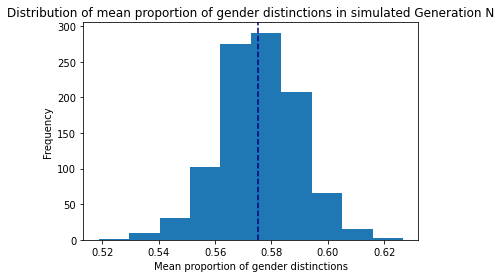

<Figure size 432x288 with 0 Axes>

In [67]:
plot = ge_sim_mean_gn.plot.hist()
plot.axvline(x=0.5754,linestyle = '--', color = 'navy')
plt.title(label='Distribution of mean proportion of gender distinctions in simulated Generation N')
plt.xlabel('Mean proportion of gender distinctions')

plt.show()
plt.savefig('../plots/sanity_ge_gn.png')

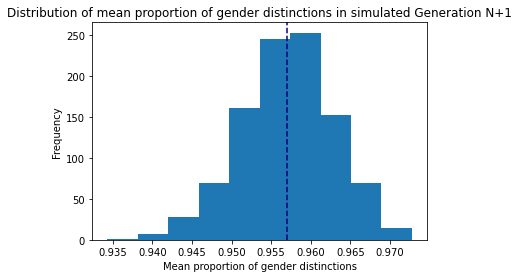

<Figure size 432x288 with 0 Axes>

In [68]:
plot = ge_sim_mean_gn1.plot.hist()
plot.axvline(x=0.9570,linestyle='--',color='navy')
plt.title('Distribution of mean proportion of gender distinctions in simulated Generation N+1')
plt.xlabel('Mean proportion of gender distinctions')

plt.show()
plt.savefig('../plots/sanity_ge_gn1.png')

## Age

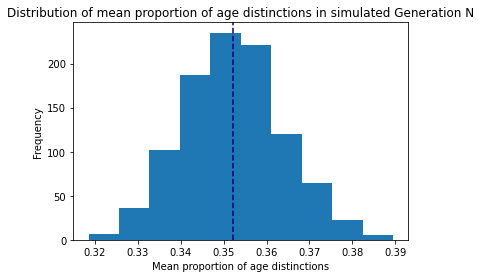

<Figure size 432x288 with 0 Axes>

In [69]:
plot = ag_sim_mean_gn.plot.hist()
plot.axvline(x=0.352162,linestyle = '--', color = 'navy')
plt.title(label='Distribution of mean proportion of age distinctions in simulated Generation N')
plt.xlabel('Mean proportion of age distinctions')

plt.show()
plt.savefig('../plots/sanity_ag_gn.png')

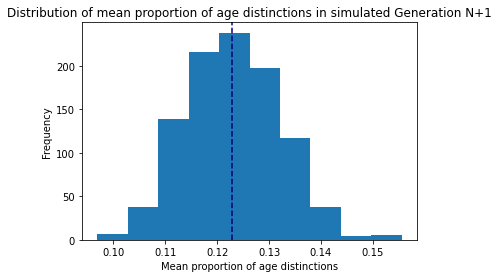

<Figure size 432x288 with 0 Axes>

In [70]:
plot = ag_sim_mean_gn1.plot.hist()
plot.axvline(x=0.1229,linestyle = '--', color = 'navy')
plt.title(label='Distribution of mean proportion of age distinctions in simulated Generation N+1')
plt.xlabel('Mean proportion of age distinctions')

plt.show()
plt.savefig('../plots/sanity_ag_gn1.png')

## Side of the family

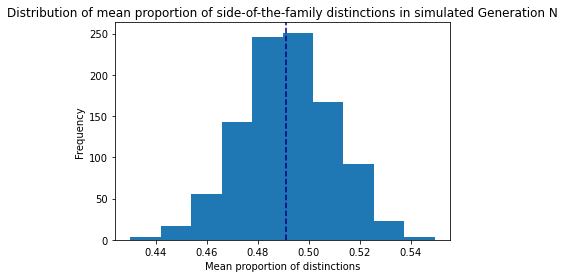

<Figure size 432x288 with 0 Axes>

In [71]:
plot = si_sim_mean_gn.plot.hist()
plot.axvline(x=0.490977,linestyle = '--', color = 'navy')
plt.title(label='Distribution of mean proportion of side-of-the-family distinctions in simulated Generation N')
plt.xlabel('Mean proportion of distinctions')

plt.show()
plt.savefig('../plots/sanity_si_gn.png')

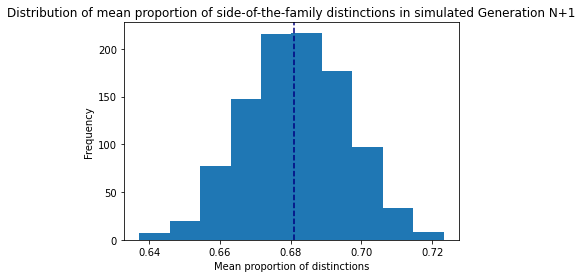

<Figure size 432x288 with 0 Axes>

In [72]:
plot = si_sim_mean_gn1.plot.hist()
plot.axvline(x=0.680989,linestyle = '--', color = 'navy')
plt.title(label='Distribution of mean proportion of side-of-the-family distinctions in simulated Generation N+1')
plt.xlabel('Mean proportion of distinctions')

plt.show()
plt.savefig('../plots/sanity_si_gn1.png')

I did it! As they should be, the means of all the simulations are approximately normally distributed, with the kinbank mean (dotted line) at the centre. Time to do some actual science.

# Old code snippets

Ignore this section. I am saving some snippets of code here that ended up getting replaced with better, more efficient solutions in case I need to refer back to them.

In [51]:

# def calculate_probs(pairs,known_terms,index=0):
#     probs = []
#     known_terms = list(known_terms.values())
#     pairs = list(pairs.values())
    
#     for pair in set(pairs):
#         p_ab = pairs.count(pair)/len(pairs)
#         p_b = known_terms.count(pair[index])/len(known_terms)
        
#         print(pairs.count(pair),len(pairs),p_ab)
#         probs.append(p_ab/p_b)
        
#     return probs

def calculate_probs(pairs,known_terms):
    probs = []
    pairs = list(set(pairs.values()))
    known_terms = set(known_terms.values())
    
    print(pairs)
    print(known_terms)
    
    # count number of pairs term x appears in
    
    for term in known_terms:
        print(term)
        counter = 0
        possible_pairs = []
        for pair in pairs:
            if pair[0] == term:
                counter += 1
                possible_pairs.append(pair[1])
            elif pair[1] == term:
                counter += 1
                possible_pairs.append(pair[0])
            

        number_of_pairs = len(possible_pairs)
            
        print(number_of_pairs, counter)

        p = number_of_pairs / counter
    
    return probs

# def calculate_probs(known_terms,list_of_pairs):
#     all_probs = []
    
#     known_terms = set(list(known_terms.values()))
    
#     for term in known_terms:
#         print(term)
#         probs = []
#         possible_pairs = []
#         for pair in list_of_pairs.values():
#             if pair[0] == term:
#                 possible_pairs.append(pair[1])
#             elif pair[1] == term:
#                 possible_pairs.append(pair[0])
        
#         for pairing in possible_pairs:
#             print(pairing)
#             p = possible_pairs.count(pairing) / len(possible_pairs)
#             print(p)
#             probs.append(p)
#             if sum(probs) == 1:
#                 all_probs.append(probs)
#                 print(all_probs)
#                 break

#     return [x for y in all_probs for x in y]